In [25]:
import numpy as np
#first some imports
import torch
torch.set_default_dtype(torch.float64)  # double precision for numerical stability

import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist
import pyro.poutine as poutine

### Playground

Illustration of building marginal dist. from a sampling function

(array([ 5.,  3., 15.,  9., 12., 18., 17.,  7.,  7.,  7.]),
 array([ 997.6676095 ,  998.08823414,  998.50885877,  998.9294834 ,
         999.35010804,  999.77073267, 1000.19135731, 1000.61198194,
        1001.03260658, 1001.45323121, 1001.87385584]),
 <a list of 10 Patch objects>)

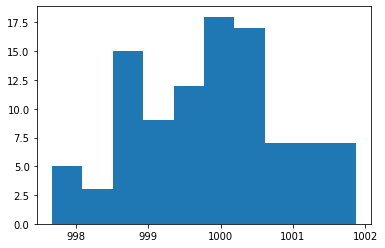

In [26]:
def foo():
    return pyro.sample("a", pyro.distributions.Normal(1000,1))

# make the marginal distributions on return values explicit:
posterior = pyro.infer.Importance(foo, num_samples=100) # other sampling methods e.g. NUTS
marginal = pyro.infer.EmpiricalMarginal(posterior.run())
plt.hist(marginal._get_samples_and_weights()[0]) # return tuple, [0]:samples and [1]:weights

In [27]:
pyro.sample('foo', marginal)

tensor(999.0523)

### Help functions

In [49]:
def Infer(sampling_func, num_samples=100):
    return(pyro.infer.EmpiricalMarginal(
        pyro.infer.Importance(
            sampling_func, num_samples=num_samples).run()))

In [29]:
def factor(name, value):
    """
    Like factor in webPPL, adds a scalar weight to the log-probability of the trace. Function from
    search_inference.py
    """
    value = value if torch.is_tensor(value) else torch.tensor(value)
    d = dist.Bernoulli(logits=value)
    pyro.sample(name, d, obs=torch.ones(value.size()))

In [30]:
def state_prior():  # state 0,1,2,3,4
    return pyro.sample("state", dist.Categorical(probs=torch.ones(5) / 5))

def utterance_prior():  # utterance 0:none, 1:some, 2:all
    return pyro.sample("utt", dist.Categorical(probs=torch.ones(3) / 3))

In [31]:
meanings = {
    0: lambda N: N==0,
    1: lambda N: N>0,
    2: lambda N: N==4,
}

def meaning(utterance, state):
    return meanings[utterance](state)

http://www.problang.org/images/rsa_schema.png

### Literal listener

In [32]:
def literal_listener(utterance):
    def sample_ll():
        state = state_prior()
        factor("literal_meaning", 0. if meaning(utterance, state) else -999999.)
        return state
    return Infer(sample_ll)

(array([18.,  0.,  0., 30.,  0.,  0., 25.,  0.,  0., 27.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

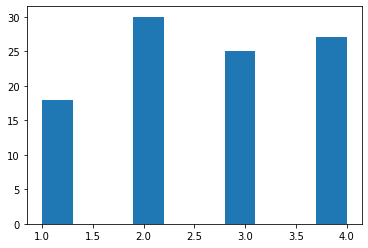

In [33]:
samples_ll = np.zeros(100)
for s in range(100):
    samples_ll[s] = pyro.sample('fooba',literal_listener(1)) # some(1) return state 1,2,3,4 equiprob.
plt.hist(samples_ll)

### Speaker

In [34]:
def speaker(state): # p(u|s)
    def sample_s():
        alpha = 1.  # optimality
        with poutine.scale(scale=torch.tensor(alpha)):
            utterance = utterance_prior() 
            pyro.sample("listener", literal_listener(int(utterance)), 
                        obs=state) # equi. to .score(state) in webPPL
        return utterance
    return Infer(sample_s)

(array([ 2.,  0.,  0.,  0.,  0., 24.,  0.,  0.,  0., 74.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

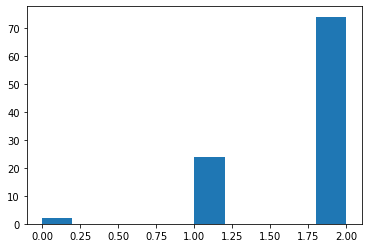

In [35]:
# if state=4 say some(1) or all(2) although all is more likely
state_samples = np.zeros(100)
for i in range(100):
    state_samples[i] = pyro.sample('foobi', speaker(4))
plt.hist(state_samples)

### Pragmatic listener

In [36]:
def pragmatic_listener(utterance):
    def sample_pl():
        state = state_prior() # p(s)
        pyro.sample("speaker", speaker(int(state)), obs=utterance) # p(u|s)
        return state
    return Infer(sample_pl)

In [38]:
pyro.sample('foobe', pragmatic_listener(1)) # if someone says some(1) the state should be 1,2,3 

tensor(1)

### Plot

In [ ]:
utterance_dict = {'none':0, 'some':1, 'all':2}
samples = np.zeros(1000)
for s in range(0,1000):
    success = False
    while not success: # sometimes sampling results in the following error (only for pragmatic listener)
        # "invalid multinomial distribution (encountering probability entry < 0)"
        try:
            samples[s] = pyro.sample("pragmatic listener", pragmatic_listener(utterance_dict['some']))
            success = True
            if s % 10 == 0:
                print(s)
        except RuntimeError:
            pass
        

(array([28.,  0.,  0., 21.,  0.,  0., 36.,  0.,  0., 15.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

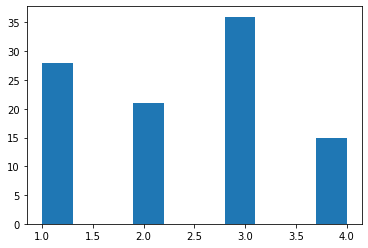

In [45]:
plt.hist(samples)